In [1]:
import sklearn
import pandas as pd
import numpy as np
import nltk
import sklearn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import train_test_split
import re
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import pickle
from wordcloud import WordCloud

In [2]:
hand_labels = pd.read_csv("../../input_data/full_datasets/fully_hand_labelled_texts.csv")

In [3]:
hand_labels

,Unnamed: 0,label_id,text,Roken,Alcohol,Drugs
0,0,1.0,Beloop: _x000D_\nPatiÃ«nte heeft 10 minuten va...,Niets gevonden,Niets gevonden,Niets gevonden
1,1,1.0,Beloop: _x000D_\nG5P4 36 wkGrav 1e lijnALL gee...,Niets gevonden,Niets gevonden,Niets gevonden
2,2,1.0,Conclusie: _x000D_\nNormale nacontrole. Kijkt ...,Niets gevonden,Niets gevonden,Niets gevonden
3,3,1.0,Beleid: _x000D_\nAlgemeen: Dagopname voor 3x P...,Niets gevonden,Niets gevonden,Niets gevonden
4,4,1.0,Anamnese: _x000D_\n34W4D,Niets gevonden,Niets gevonden,Niets gevonden
...,...,...,...,...,...,...
4695,95,2.0,Beloop: _x000D_\nCONSULTENKAMERGezien door co-...,Geen gebruiker,Geen gebruiker,Geen gebruiker
4696,96,2.0,Reden van komst / Verwijzing: _x000D_\nReden v...,Geen gebruiker,Geen gebruiker,Geen gebruiker
4697,97,2.0,Beloop: _x000D_\nMR CPG7P4M4 // MI: 4x sectio...,Geen gebruiker,Geen gebruiker,Geen gebruiker
4698,98,2.0,Reden van komst / Verwijzing: _x000D_\nReden v...,Geen gebruiker,Geen gebruiker,Geen gebruiker


In [4]:
stemmer = SnowballStemmer("dutch")
np.random.seed(500)

def create_preprocess_corpus(input_csv, content_name, label_name, smoking=False, second_experiment=False, skip_rows=[]):
    corpus = pd.read_csv(input_csv,encoding='latin-1', skiprows=skip_rows)
    corpus = corpus.rename({content_name:'text', label_name: 'label'}, axis=1)
    corpus['text'] = corpus['text'].str.replace('_x000D_\n',' ')
    corpus['text'] = corpus['text'].str.replace('Ã«','ë')
    corpus.drop(['Unnamed: 0'], axis=1, inplace=True)
    corpus.drop_duplicates(inplace=True)
    corpus['text'] = corpus['text'].astype(str)
    corpus['text'] = corpus['text'].str.lower()
    #corpus['text'].replace(to_replace="[^\w\s]", value="", regex=True, inplace=True)
    corpus['text'] = [stemmer.stem(text) for text in corpus['text']]
    if second_experiment:
        if smoking:
            replace_text = 'Rookt niet'
            corpus['label'] = corpus['label'].str.replace('Niets gevonden', 'Rookt niet')
            corpus['label'] = corpus['label'].str.replace('Rookte', 'Rookt niet')
        else:
            corpus['label'] = corpus['label'].str.replace('Niets gevonden', 'Nee')
        
    corpus = corpus.drop(corpus[corpus.label == '--'].index)
    corpus = corpus.drop(corpus[corpus.label == 'Onbekend'].index)
    corpus_backup = corpus.copy()
    return corpus, corpus_backup

def create_original_corpus(input_csv, content_name, label_name, skip_rows=[]):
    corpus = pd.read_csv(input_csv,encoding='latin-1', skiprows=skip_rows)
    corpus = corpus.rename({content_name:'text', label_name: 'label'}, axis=1)
    corpus_backup = corpus.copy()
    return corpus, corpus_backup

In [5]:
full_hand_smoking_set, full_hand_smoking_set_backup = create_preprocess_corpus("../../input_data/full_datasets/fully_hand_labelled_texts.csv", "text", "Roken")

In [6]:
full_hand_alcohol_set, full_hand_alcohol_set_backup = create_preprocess_corpus("../../input_data/full_datasets/fully_hand_labelled_texts.csv", "text", "Alcohol")

In [7]:
full_hand_drugs_set, full_hand_drugs_set_backup = create_preprocess_corpus("../../input_data/full_datasets/fully_hand_labelled_texts.csv", "text", "Drugs")

In [8]:
full_text_wordcloud = WordCloud().generate(' '.join(full_hand_smoking_set['text']))

(-0.5, 399.5, 199.5, -0.5)

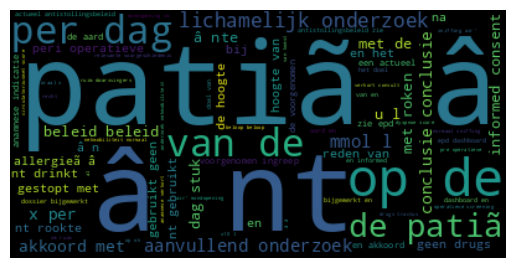

In [9]:
import matplotlib.pyplot as plt
plt.imshow(full_text_wordcloud, interpolation='bilinear')
plt.axis("off")


# Smoking

In [10]:
full_hand_smoking_set['label'].value_counts()

Niets gevonden          3143
Voormalige gebruiker     939
Geen gebruiker           439
Huidige gebruiker        179
Name: label, dtype: int64

(-0.5, 399.5, 199.5, -0.5)

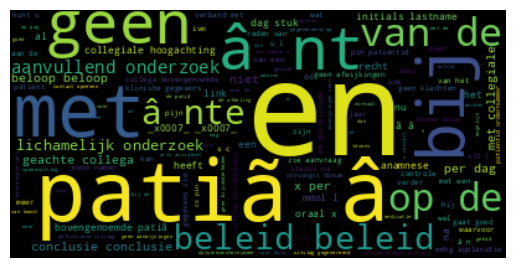

In [11]:
nothing_found_wordcloud = WordCloud().generate(' '.join(full_hand_smoking_set[full_hand_smoking_set['label'] == 'Niets gevonden']['text']))
plt.imshow(nothing_found_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

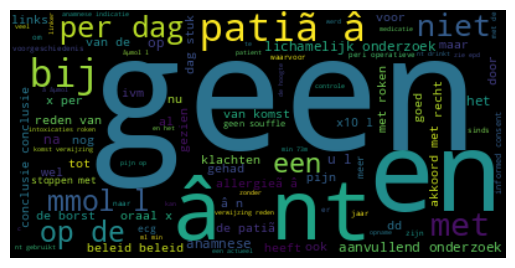

In [12]:
user_wordcloud = WordCloud().generate(' '.join(full_hand_smoking_set[full_hand_smoking_set['label'] == 'Huidige gebruiker']['text']))
plt.imshow(user_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

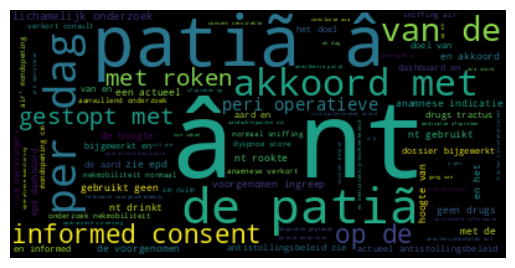

In [13]:
former_user_wordcloud = WordCloud().generate(' '.join(full_hand_smoking_set[full_hand_smoking_set['label'] == 'Voormalige gebruiker']['text']))
plt.imshow(former_user_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

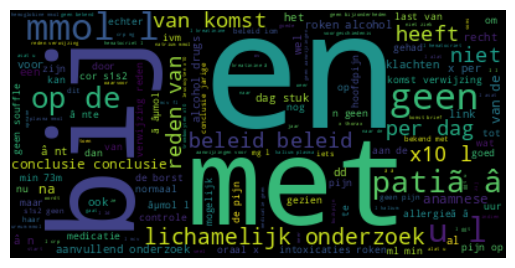

In [14]:
non_user_wordcloud = WordCloud().generate(' '.join(full_hand_smoking_set[full_hand_smoking_set['label'] == 'Geen gebruiker']['text']))
plt.imshow(non_user_wordcloud, interpolation='bilinear')
plt.axis("off")

# Drinking

In [15]:
full_hand_alcohol_set['label'].value_counts()

Niets gevonden          3321
Geen gebruiker           744
Huidige gebruiker        616
Voormalige gebruiker      19
Name: label, dtype: int64

(-0.5, 399.5, 199.5, -0.5)

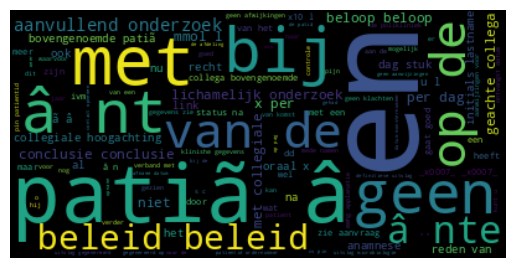

In [17]:
nothing_found_wordcloud = WordCloud().generate(' '.join(full_hand_alcohol_set[full_hand_alcohol_set['label'] == 'Niets gevonden']['text']))
plt.imshow(nothing_found_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

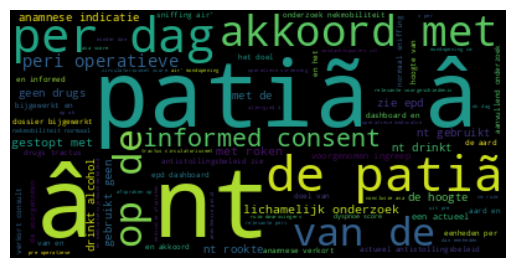

In [18]:
user_wordcloud = WordCloud().generate(' '.join(full_hand_alcohol_set[full_hand_alcohol_set['label'] == 'Huidige gebruiker']['text']))
plt.imshow(user_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

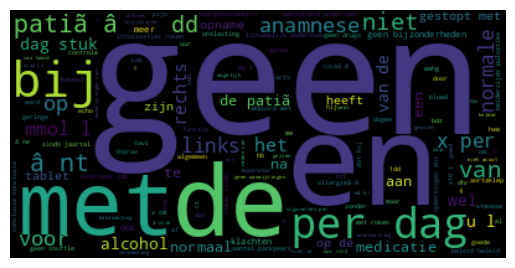

In [19]:
former_user_wordcloud = WordCloud().generate(' '.join(full_hand_alcohol_set[full_hand_alcohol_set['label'] == 'Voormalige gebruiker']['text']))
plt.imshow(former_user_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

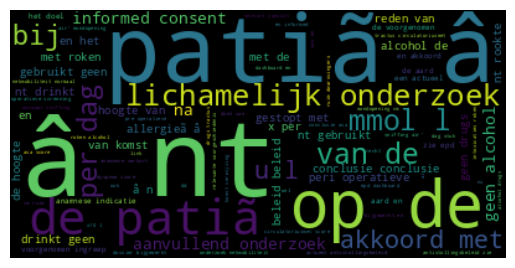

In [20]:
non_user_wordcloud = WordCloud().generate(' '.join(full_hand_alcohol_set[full_hand_alcohol_set['label'] == 'Geen gebruiker']['text']))
plt.imshow(non_user_wordcloud, interpolation='bilinear')
plt.axis("off")

# Drugs

In [16]:
full_hand_drugs_set['label'].value_counts()

Niets gevonden          3357
Geen gebruiker          1272
Huidige gebruiker         60
Voormalige gebruiker      11
Name: label, dtype: int64

(-0.5, 399.5, 199.5, -0.5)

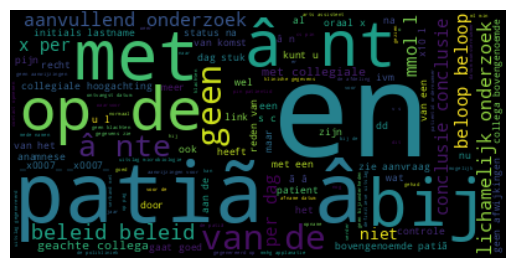

In [21]:
nothing_found_wordcloud = WordCloud().generate(' '.join(full_hand_drugs_set[full_hand_drugs_set['label'] == 'Niets gevonden']['text']))
plt.imshow(nothing_found_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

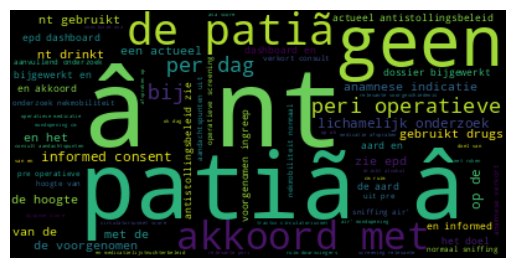

In [22]:
user_wordcloud = WordCloud().generate(' '.join(full_hand_drugs_set[full_hand_drugs_set['label'] == 'Huidige gebruiker']['text']))
plt.imshow(user_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

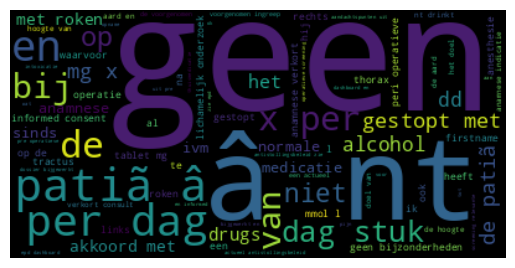

In [23]:
former_user_wordcloud = WordCloud().generate(' '.join(full_hand_drugs_set[full_hand_drugs_set['label'] == 'Voormalige gebruiker']['text']))
plt.imshow(former_user_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

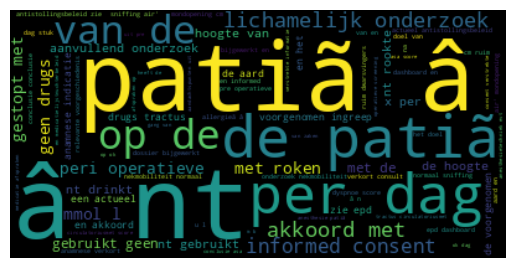

In [24]:
non_user_wordcloud = WordCloud().generate(' '.join(full_hand_drugs_set[full_hand_drugs_set['label'] == 'Geen gebruiker']['text']))
plt.imshow(non_user_wordcloud, interpolation='bilinear')
plt.axis("off")